In [3]:
! pip install -qq tensorflow tensorflow_addons

In [ ]:
! pip install xgboost
! pip install imbalanced-learn
! pip install --upgrade scikit-learn
! pip uninstall imbalanced-learn --y
! pip install imbalanced-learn

### restart the kernel for changes to reflect

## Approach 1 - AutoEncoder with loss as MSE

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

# Load data
data = pd.read_csv('creditcard.csv')
data = data[:50000]

Epoch 1/20
274/274 [==============================] - 2s 3ms/step - loss: 0.0416 - val_loss: 0.0146
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0097 - val_loss: 0.0159
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0085 - val_loss: 0.0162
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0081 - val_loss: 0.0166
Epoch 5/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0078 - val_loss: 0.0160
Epoch 6/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0075 - val_loss: 0.0150
Epoch 7/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0153
Epoch 8/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0144
Epoch 9/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0069 - val_loss: 0.0165
Epoch 10/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0152

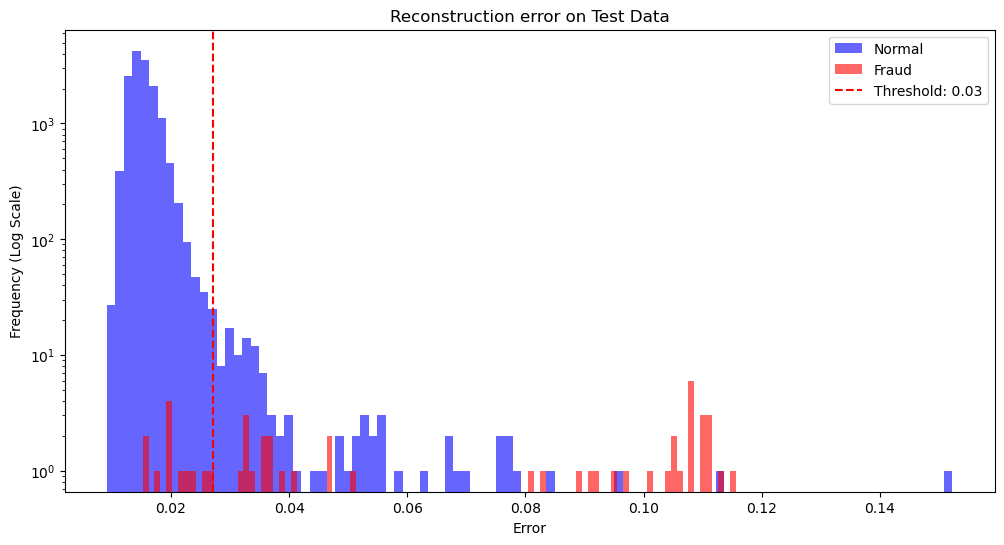

In [47]:
# Split the dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Normalize data & drop time column
train_data = train_data.drop("Time", axis=1)
normalized_train=(train_data-train_data.min())/(train_data.max()-train_data.min())

test_data = test_data.drop("Time", axis=1)
normalized_test=(test_data-test_data.min())/(test_data.max()-test_data.min())

train_x = normalized_train.drop("Class", axis=1).values
train_y = train_data["Class"].values

test_x = normalized_test.drop("Class", axis=1).values
test_y = test_data["Class"].values

# Create the autoencoder model
model = keras.Sequential(
    [
        keras.Input(shape=(29, )),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(29, activation="linear"), # changed to linear activation to reconstruct the input
    ]
)

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)
model.compile(loss="mse", optimizer=optimizer)  # using mse for autoencoders

model.fit(train_x, train_x, batch_size=128, epochs=20, validation_data=(test_x, test_x))


# Calculate reconstruction error
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# Use 99.7th percentile of train error as initial threshold
threshold = np.percentile(train_error, 99.7)
print(f"Threshold: {threshold}")

test_predictions_class = [1 if e > threshold else 0 for e in test_error]
print(classification_report(test_y, test_predictions_class))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

In [5]:
data.shape

(284807, 31)

In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Approach 2: Autoencoder with loss as binary cross entropy

Epoch 1/20
274/274 [==============================] - 2s 3ms/step - loss: 0.6094 - val_loss: 0.6158
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5947 - val_loss: 0.6144
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5943 - val_loss: 0.6148
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5943 - val_loss: 0.6140
Epoch 5/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5942 - val_loss: 0.6163
Epoch 6/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5942 - val_loss: 0.6144
Epoch 7/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5940 - val_loss: 0.6135
Epoch 8/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5939 - val_loss: 0.6145
Epoch 9/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5938 - val_loss: 0.6150
Epoch 10/20
274/274 [==============================] - 1s 3ms/step - loss: 0.5937 - val_loss: 0.6146

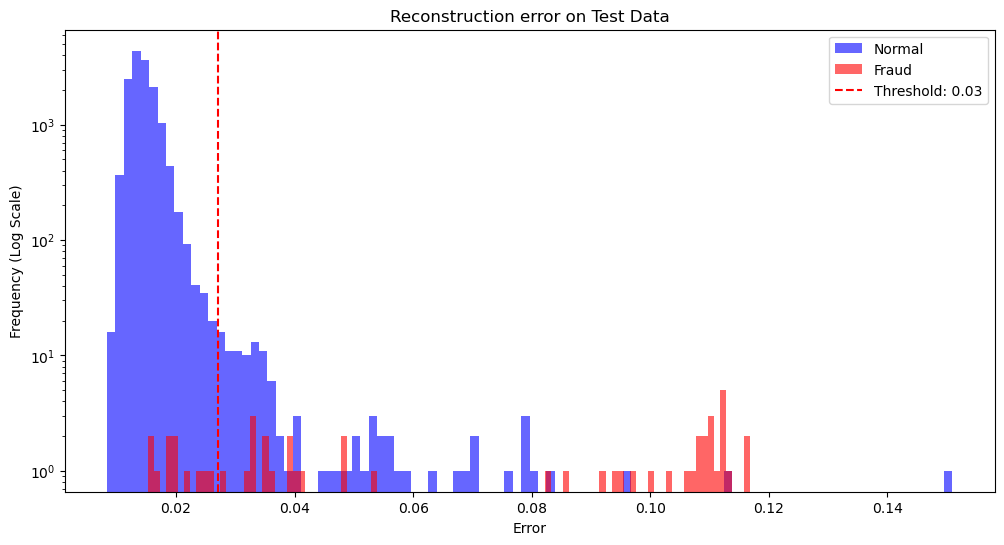

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

# Load data
data = pd.read_csv('creditcard.csv')
data = data[:50000]

# Split the dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Normalize data & drop time column
train_data = train_data.drop("Time", axis=1)
normalized_train = (train_data - train_data.min()) / (train_data.max() - train_data.min())

test_data = test_data.drop("Time", axis=1)
normalized_test = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_x = normalized_train.drop("Class", axis=1).values
train_y = train_data["Class"].values

test_x = normalized_test.drop("Class", axis=1).values
test_y = test_data["Class"].values

# Create the autoencoder model with binary cross-entropy loss
model = keras.Sequential(
    [
        keras.Input(shape=(29,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(29, activation="sigmoid"),  # Changed to sigmoid activation for binary cross-entropy
    ]
)

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)
model.compile(loss="binary_crossentropy", optimizer=optimizer)  # Using binary cross-entropy for autoencoders

model.fit(train_x, train_x, batch_size=128, epochs=20, validation_data=(test_x, test_x))

# Calculate reconstruction error
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# Use 99.5th percentile of train error as initial threshold
threshold = np.percentile(train_error, 99.7)
print(f"Threshold: {threshold}")

test_predictions_class = [1 if e > threshold else 0 for e in test_error]
print(classification_report(test_y, test_predictions_class))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

## Approach 3: isolation random forest technqiue

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.38      0.29      0.33       136

    accuracy                           1.00     85443
   macro avg       0.69      0.64      0.66     85443
weighted avg       1.00      1.00      1.00     85443

[[85243    64]
 [   97    39]]


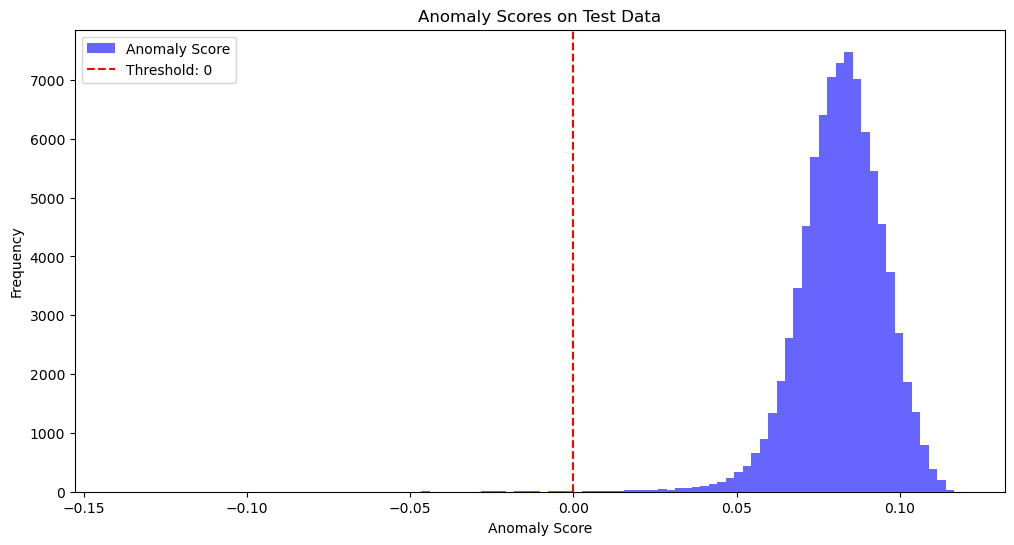

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Load your dataset (replace 'data.csv' with the actual filename)
data = pd.read_csv('creditcard.csv')

# Drop the 'Time' column
data = data.drop("Time", axis=1)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Separate majority (non-fraud) and minority (fraud) classes
train_majority = train_data[train_data['Class'] == 0]
train_minority = train_data[train_data['Class'] == 1]

# Undersample the majority class to balance the dataset
train_majority_undersampled = train_majority.sample(n=len(train_minority), random_state=42)

# Combine minority class and undersampled majority class
train_balanced = pd.concat([train_majority_undersampled, train_minority])

# Normalize the data (excluding the 'Class' column)
normalized_train = (train_balanced - train_balanced.min()) / (train_balanced.max() - train_balanced.min())
normalized_test = (test_data - test_data.min()) / (test_data.max() - test_data.min())

# Split features and labels
train_x = normalized_train.drop("Class", axis=1).values
train_y = train_balanced["Class"].values

test_x = normalized_test.drop("Class", axis=1).values
test_y = test_data["Class"].values

# Train an Isolation Forest model for anomaly detection
model = IsolationForest(contamination=0.03, random_state=42)
model.fit(train_x)

# Predict anomalies on the test set
test_predictions = model.predict(test_x)

# Convert predictions (-1 for anomalies, 1 for normal) to 0 for normal, 1 for anomaly
test_predictions_class = [0 if e == 1 else 1 for e in test_predictions]

# Evaluate the model
print(classification_report(test_y, test_predictions_class))
print(confusion_matrix(test_y, test_predictions_class))

# Visualization of the anomaly scores
anomaly_scores = model.decision_function(test_x)
plt.figure(figsize=(12, 6))
plt.hist(anomaly_scores, bins=100, label='Anomaly Score', color='blue', alpha=0.6)
plt.axvline(x=0, color='r', linestyle='--', label='Threshold: 0')
plt.title('Anomaly Scores on Test Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Approach 4- OneClassSVM

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     14948
           1       0.12      0.73      0.20        52

    accuracy                           0.98     15000
   macro avg       0.56      0.86      0.59     15000
weighted avg       1.00      0.98      0.99     15000

[[14656   292]
 [   14    38]]


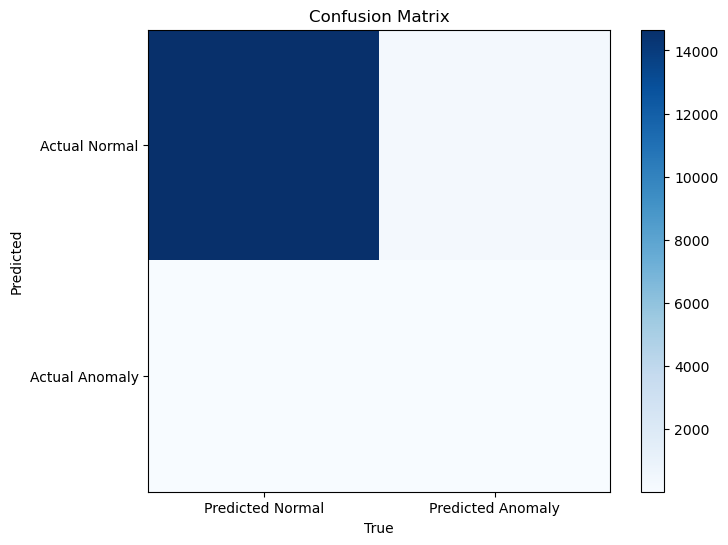

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Load your dataset (replace 'data.csv' with the actual filename)
data = pd.read_csv('creditcard.csv')
data = data[:50000]

# Drop the 'Time' column
data = data.drop("Time", axis=1)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
train_x = scaler.fit_transform(train_data.drop("Class", axis=1).values)
test_x = scaler.transform(test_data.drop("Class", axis=1).values)

train_y = train_data["Class"].values
test_y = test_data["Class"].values

# Create and train the one-class SVM model
model = OneClassSVM(kernel='rbf', nu=0.01)  # Adjust nu as needed
model.fit(train_x)

# Predict anomalies on the test set
test_predictions = model.predict(test_x)

# Map SVM output labels to 0 (normal) and 1 (anomaly)
test_predictions[test_predictions == 1] = 0  # Normal
test_predictions[test_predictions == -1] = 1  # Anomaly

# Evaluate the model
print(classification_report(test_y, test_predictions))
print(confusion_matrix(test_y, test_predictions))

# Visualization of the confusion matrix
conf_matrix = confusion_matrix(test_y, test_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], labels=['Predicted Normal', 'Predicted Anomaly'])
plt.yticks([0, 1], labels=['Actual Normal', 'Actual Anomaly'])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()


## Approach 5: Ensemble approach- oneclassSVM and Autoencoder

Epoch 1/50
219/219 [==============================] - 1s 3ms/step - loss: 0.7935 - val_loss: 0.5041
Epoch 2/50
219/219 [==============================] - 1s 2ms/step - loss: 0.5829 - val_loss: 0.3825
Epoch 3/50
219/219 [==============================] - 1s 2ms/step - loss: 0.5029 - val_loss: 0.3105
Epoch 4/50
219/219 [==============================] - 1s 2ms/step - loss: 0.4524 - val_loss: 0.2892
Epoch 5/50
219/219 [==============================] - 1s 2ms/step - loss: 0.4302 - val_loss: 0.2562
Epoch 6/50
219/219 [==============================] - 1s 2ms/step - loss: 0.4089 - val_loss: 0.2283
Epoch 7/50
219/219 [==============================] - 1s 2ms/step - loss: 0.3969 - val_loss: 0.2282
Epoch 8/50
219/219 [==============================] - 1s 2ms/step - loss: 0.3804 - val_loss: 0.2131
Epoch 9/50
219/219 [==============================] - 1s 2ms/step - loss: 0.3761 - val_loss: 0.2261
Epoch 10/50
219/219 [==============================] - 1s 2ms/step - loss: 0.3760 - val_loss: 0.1911

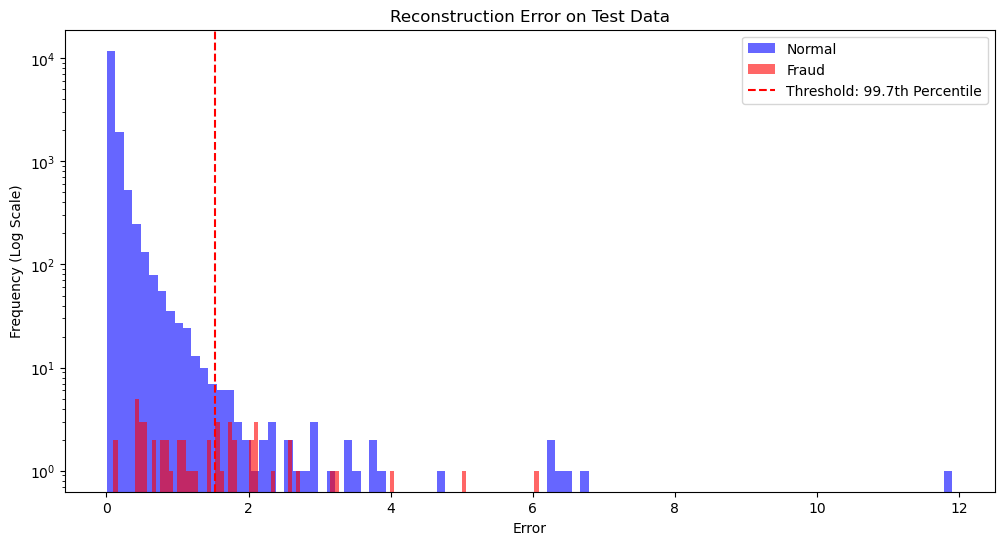

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models

# Load your dataset (replace 'data.csv' with the actual filename)
data = pd.read_csv('creditcard.csv')
data = data[:50000]

# Drop the 'Time' column
data = data.drop("Time", axis=1)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
train_x = scaler.fit_transform(train_data.drop("Class", axis=1).values)
test_x = scaler.transform(test_data.drop("Class", axis=1).values)

train_y = train_data["Class"].values
test_y = test_data["Class"].values

# Create and train the autoencoder model
model = models.Sequential()
model.add(layers.Input(shape=(29,)))

# Autoencoder architecture
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(29, activation='linear'))  # Output layer

# Compile the autoencoder model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
model.fit(train_x, train_x, batch_size=128, epochs=50, validation_split=0.2)

# Calculate reconstruction error for both train and test sets
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# Create and train the one-class SVM model on the autoencoder features
svm_model = OneClassSVM(kernel='rbf', nu=0.01)
svm_model.fit(train_error.reshape(-1, 1))

# Predict anomalies on the test set using the one-class SVM
svm_predictions = svm_model.predict(test_error.reshape(-1, 1))

# Map SVM output labels to 0 (normal) and 1 (anomaly)
svm_predictions[svm_predictions == 1] = 0  # Normal
svm_predictions[svm_predictions == -1] = 1  # Anomaly

# Evaluate the ensemble's performance
print(classification_report(test_y, svm_predictions))
print(confusion_matrix(test_y, svm_predictions))

# Visualization of the reconstruction errors
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=np.percentile(test_error[test_y == 0], 99.7), color='r', linestyle='--', label=f'Threshold: 99.7th Percentile')
plt.title('Reconstruction Error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

## Approach 6: Hypeparamter tuning to Approach 1

Trial 10 Complete [00h 00m 19s]
val_loss: 0.013964974321424961

Best val_loss So Far: 0.01258241105824709
Total elapsed time: 00h 05m 27s
469/469 [==============================] - 0s 865us/step
Threshold: 0.014180909890724094
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     14948
           1       0.03      0.96      0.06        52

    accuracy                           0.89     15000
   macro avg       0.51      0.92      0.50     15000
weighted avg       1.00      0.89      0.94     15000



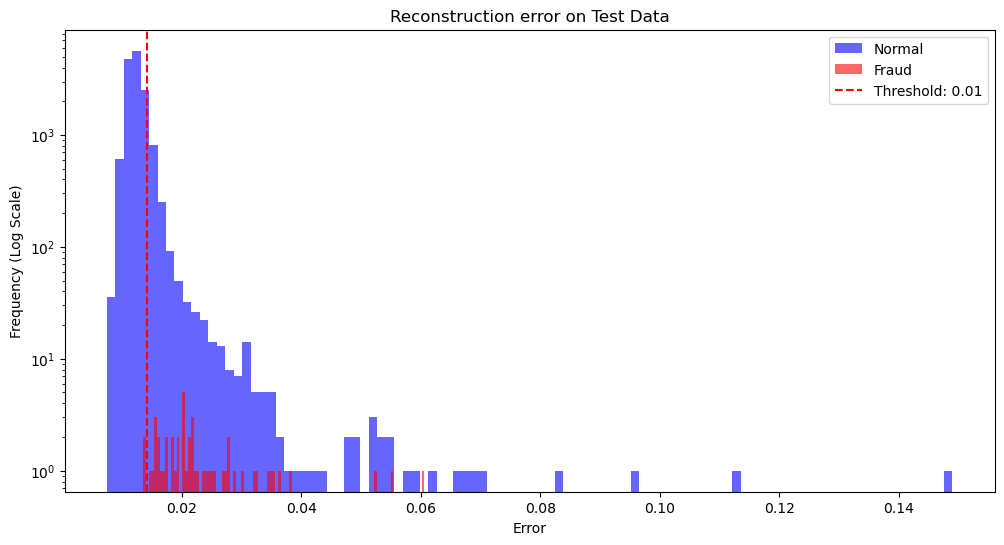

In [34]:
#!pip install keras-tuner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons import optimizers
from kerastuner.tuners import RandomSearch
# Import EarlyStopping from Keras
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.engine.hyperparameters import HyperParameters

# Load data
data = pd.read_csv('creditcard.csv')
data = data[:50000]
# Split the dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Normalize data & drop time column
train_data = train_data.drop("Time", axis=1)
normalized_train = (train_data - train_data.min()) / (train_data.max() - train_data.min())

test_data = test_data.drop("Time", axis=1)
normalized_test = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_x = normalized_train.drop("Class", axis=1).values
train_y = train_data["Class"].values

test_x = normalized_test.drop("Class", axis=1).values
test_y = test_data["Class"].values

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(29,)))
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 256, 32), activation='relu'))
        model.add(layers.Dropout(rate=hp.Float('dropout_' + str(i), 0, 0.5, step=0.1)))
    model.add(layers.Dense(29, activation="linear"))
    optimizer = optimizers.AdamW(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'), weight_decay=hp.Float('weight_decay', 1e-4, 1e-2, sampling='log'))
    model.compile(loss="mse", optimizer=optimizer)
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='autoencoder_tuning',
    project_name='credit_card_fraud'
)

tuner.search(train_x, train_x, epochs=20, validation_data=(test_x, test_x), callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Calculate reconstruction error
train_predictions = best_model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = best_model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

threshold = np.percentile(train_error, 99.7)
print(f"Threshold: {threshold}")

test_predictions_class = [1 if e > threshold else 0 for e in test_error]
print(classification_report(test_y, test_predictions_class))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

## Approach 7: SMOTE+XgBoost

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Load your dataset (replace 'data.csv' with the actual filename)
data = pd.read_csv('creditcard.csv')
data = data[:50000]

# Separate features and target variable
X = data.drop("Class", axis=1)
y = data["Class"]

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train an XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f58b2c085e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14948
           1       0.96      0.94      0.95        52

    accuracy                           1.00     15000
   macro avg       0.98      0.97      0.98     15000
weighted avg       1.00      1.00      1.00     15000



## Approach 8: Autoencoder with SMOTE+XgBoost

Epoch 1/20
274/274 [==============================] - 2s 4ms/step - loss: 0.0470 - val_loss: 0.0151
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0106 - val_loss: 0.0164
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.0171
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0084 - val_loss: 0.0153
Epoch 5/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0079 - val_loss: 0.0159
Epoch 6/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0156
Epoch 7/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0157
Epoch 8/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0156
Epoch 9/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0069 - val_loss: 0.0150
Epoch 10/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0067 - val_loss: 0.0152

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f473fce17e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Threshold: 0.01713630535160065
Classification Report for the Ensemble Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14948
           1       0.68      0.88      0.77        52

    accuracy                           1.00     15000
   macro avg       0.84      0.94      0.88     15000
weighted avg       1.00      1.00      1.00     15000



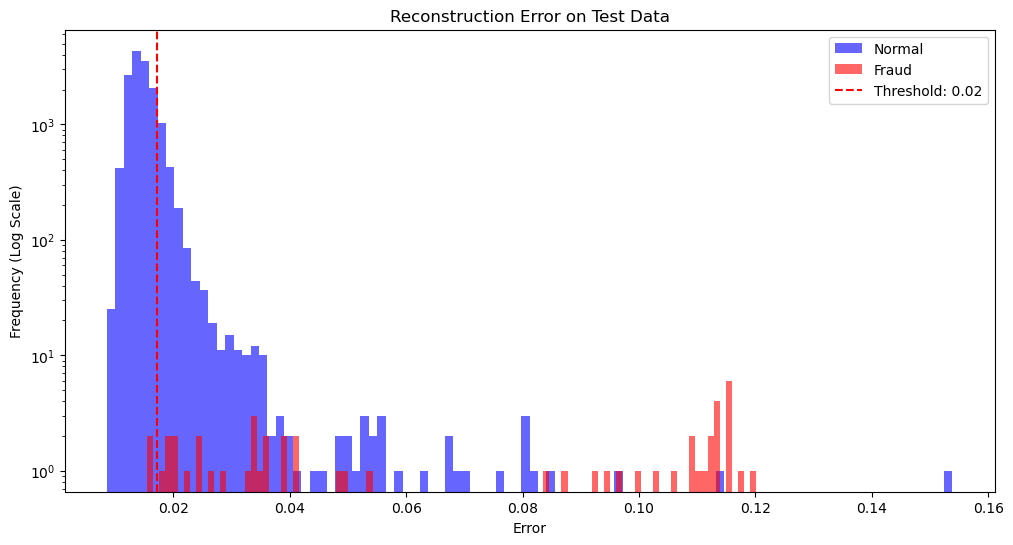

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import xgboost as xgb
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# Load data
data = pd.read_csv('creditcard.csv')
data = data[:50000]

# Split the dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Normalize data & drop time column
train_data = train_data.drop("Time", axis=1)
normalized_train = (train_data - train_data.min()) / (train_data.max() - train_data.min())

test_data = test_data.drop("Time", axis=1)
normalized_test = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_x = normalized_train.drop("Class", axis=1).values
train_y = train_data["Class"].values

test_x = normalized_test.drop("Class", axis=1).values
test_y = test_data["Class"].values

# Create the autoencoder model
model = keras.Sequential(
    [
        keras.Input(shape=(29,)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(29, activation="linear"),
    ]
)

optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)
model.compile(loss="mse", optimizer=optimizer)

model.fit(train_x, train_x, batch_size=128, epochs=20, validation_data=(test_x, test_x))

# Calculate reconstruction error
train_predictions = model.predict(train_x)
train_error = np.mean(np.square(train_x - train_predictions), axis=1)

test_predictions = model.predict(test_x)
test_error = np.mean(np.square(test_x - test_predictions), axis=1)

# Use 99.7th percentile of train error as initial threshold
threshold = np.percentile(train_error, 99.5)
print(f"Threshold: {threshold}")

# Identify anomalies based on the threshold
test_predictions_class = [1 if e > threshold else 0 for e in test_error]

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_x_resampled, train_y_resampled = smote.fit_resample(train_x, train_y)

# Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
xgb_model.fit(train_x_resampled, train_y_resampled)

# Predict using the XGBoost model
xgb_predictions = xgb_model.predict(test_x)

# Evaluate the ensemble model


# Ensemble Decision: Require both models to agree on fraud
ensemble_predictions = [1 if auto == 1 and xgb == 1 else 0 for auto, xgb in zip(test_predictions_class, xgb_predictions)]

# Evaluation of the ensemble model
print("Classification Report for the Ensemble Model:")
print(classification_report(test_y, ensemble_predictions))

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(test_error[test_y == 0], bins=100, label='Normal', color='blue', alpha=0.6, log=True)
plt.hist(test_error[test_y == 1], bins=100, label='Fraud', color='red', alpha=0.6)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.title('Reconstruction Error on Test Data')
plt.xlabel('Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

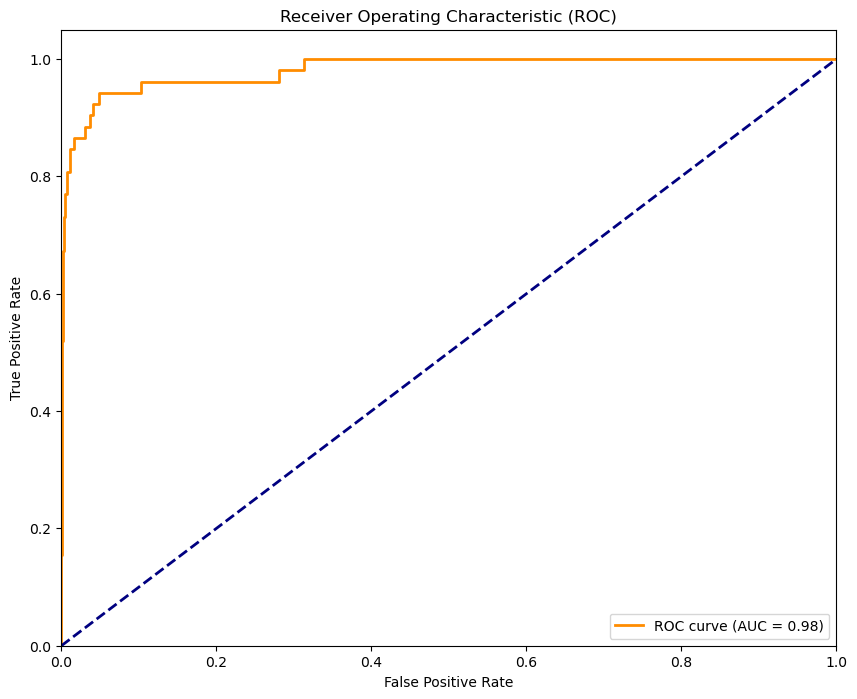

In [7]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test_error)

# Calculate the AUC (area under the curve)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()